### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/v14.1_updated_ihd_cause/alabama/2023_05_17_13_41_54/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/v14.1_updated_ihd_cause/alabama/2023_05_17_13_41_54/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27044.205339
1,25_to_29,female,2023,232,27050.951403
2,25_to_29,female,2023,357,26879.003422
3,25_to_29,female,2023,394,26896.941821
4,25_to_29,female,2023,602,26573.207392


In [5]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,300000)
        plt.grid()

### BMI

In [6]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,835342.938028
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,843508.012001
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,808180.006982
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,788473.117387
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,794752.141232


In [7]:
bmi_exp = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,835342.938028
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,843508.012001
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,808180.006982
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,788473.117387
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,794752.141232


In [8]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,826831.307275,818226.617350,835016.531721
1,25_to_29,female,2024,818063.105481,808113.026522,826544.110260
2,25_to_29,female,2025,811181.331140,800980.307283,817938.981588
3,25_to_29,female,2026,806635.981578,794671.954932,813639.059869
4,25_to_29,female,2027,803397.895730,795624.669439,812399.415802


In [9]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [10]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,female,2023,30.762327,30.739529,30.434777,31.058220
1,25_to_29,female,2024,30.755999,30.749406,30.437443,31.025166
2,25_to_29,female,2025,30.747206,30.752919,30.442738,30.997063
3,25_to_29,female,2026,30.748320,30.768006,30.454296,30.973365
4,25_to_29,female,2027,30.735764,30.755542,30.431195,30.970812


In [11]:
%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [12]:
risk_exp['risk'].unique()

array(['high_body_mass_index_in_adults', 'high_fasting_plasma_glucose',
       'high_ldl_cholesterol', 'high_systolic_blood_pressure'],
      dtype=object)

In [13]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,110.019992,107.827623,112.617513
1,25_to_29,female,2024,109.999825,107.817869,112.628003
2,25_to_29,female,2025,109.993100,107.854415,112.591276
3,25_to_29,female,2026,109.987779,107.899640,112.559718
4,25_to_29,female,2027,109.989426,107.896551,112.531766


In [14]:
%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [15]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.631618,2.557853,2.801237
1,25_to_29,female,2024,2.632275,2.561227,2.802359
2,25_to_29,female,2025,2.634123,2.560550,2.804952
3,25_to_29,female,2026,2.634476,2.561080,2.804938
4,25_to_29,female,2027,2.635631,2.560678,2.804495


In [16]:
%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [17]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,5.342231,4.841177,6.203856
1,25_to_29,female,2024,5.340622,4.842843,6.204190
2,25_to_29,female,2025,5.338793,4.843276,6.198966
3,25_to_29,female,2026,5.339315,4.841922,6.195677
4,25_to_29,female,2027,5.338480,4.843022,6.195993


In [18]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [19]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  alabama_before_calculated_pafs.hdf  raw_data/  washington.hdf


In [20]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [21]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [22]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [23]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [24]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,30.865099,30.817930,30.517198,31.247504,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,31.607178,31.645317,31.349718,31.799262,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,31.826059,31.814623,31.613541,32.037692,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,32.237747,32.229013,32.032432,32.462008,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,32.094423,32.126050,31.895619,32.243715,Alabama,exposure,45_to_49


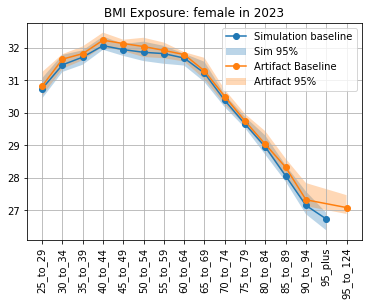

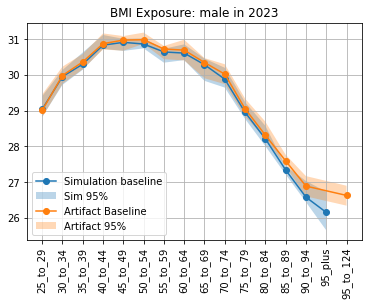

In [25]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

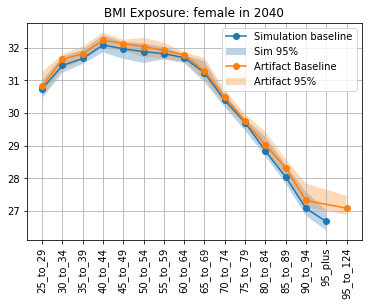

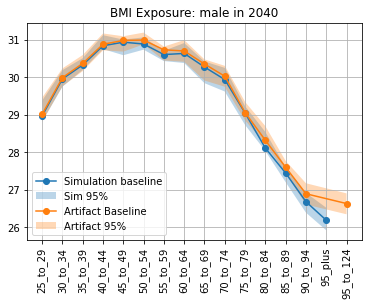

In [26]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [27]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,110.368871,110.550012,108.058728,112.836037,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,112.716383,112.890663,110.383748,114.825715,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,115.954006,116.037457,114.308780,118.622261,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,118.174272,118.486604,115.793743,120.403610,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,121.600194,121.774540,118.304543,124.125547,Alabama,exposure,45_to_49


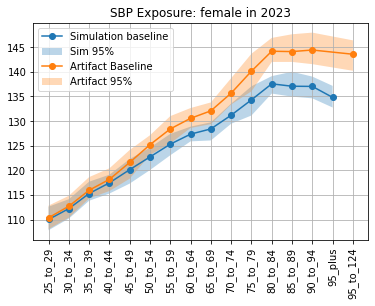

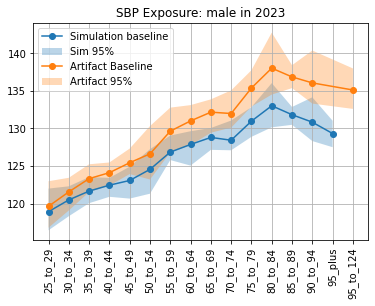

In [28]:
#Can we stratify by medication coverage? 

for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

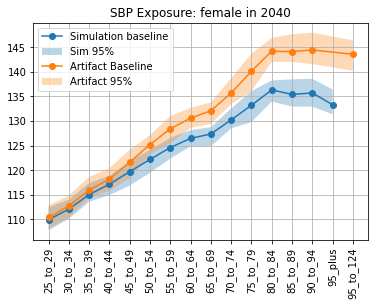

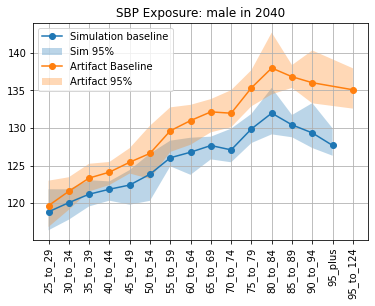

In [29]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [30]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,2.648033,2.621584,2.564638,2.822127,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,2.738259,2.740775,2.639471,2.842837,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,2.780424,2.749277,2.679930,2.907565,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,2.854641,2.852044,2.703934,3.005097,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,2.992200,2.973490,2.899741,3.126419,Alabama,exposure,45_to_49


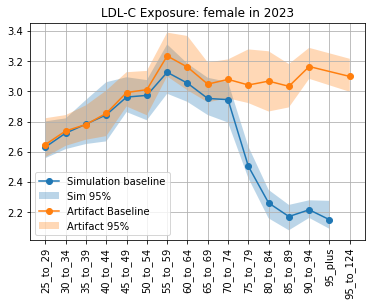

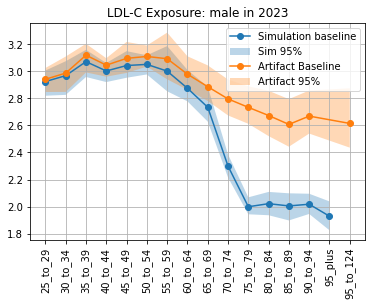

In [31]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

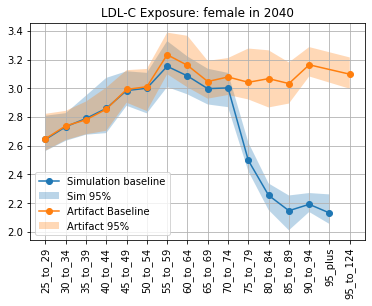

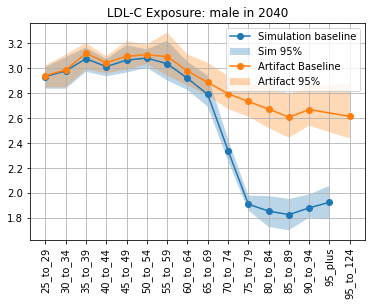

In [32]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [33]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,5.348873,5.232232,4.845785,6.205057,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,5.424154,5.403293,4.851313,6.087867,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,5.467681,5.471964,4.976055,5.910108,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,5.254983,5.280370,4.676512,5.780458,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,5.585864,5.643988,5.067206,6.121281,Alabama,exposure,45_to_49


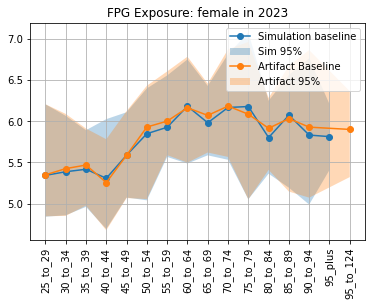

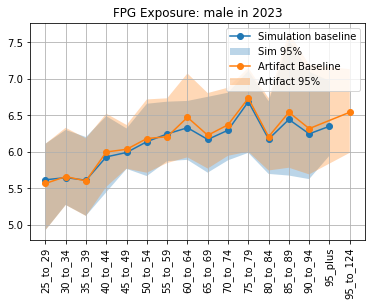

In [34]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

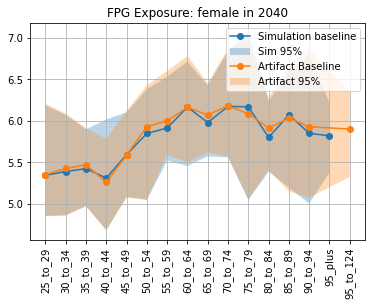

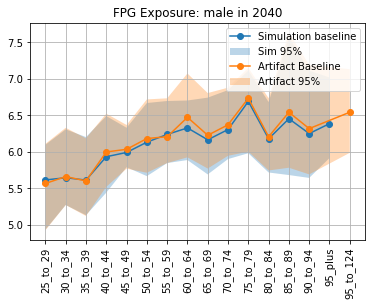

In [35]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad

# SBP Medications

In [36]:
meds = pd.read_csv(sim_results_dir + '/sbp_medication_person_time.csv')
meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,sbp_medication,value
0,0,female,2023,sbp_medication_person_time,29,baseline,25_to_29,primary_non_adherent,no_treatment,3947.980835
1,1,female,2023,sbp_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,no_treatment,2560.668036
2,2,female,2023,sbp_medication_person_time,29,baseline,25_to_29,adherent,no_treatment,17966.379192
3,3,female,2023,sbp_medication_person_time,29,baseline,30_to_34,primary_non_adherent,no_treatment,3490.321697
4,4,female,2023,sbp_medication_person_time,29,baseline,30_to_34,secondary_non_adherent,no_treatment,2281.779603


In [37]:
meds_adherent = meds.loc[meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['age', 'sex', 'year', 'sbp_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,age,sex,year,sbp_medication,mean,2.5%,97.5%
0,25_to_29,female,2023,no_treatment,0.659034,0.647778,0.665266
1,25_to_29,female,2023,one_drug_half_dose_efficacy,0.053450,0.046962,0.064433
2,25_to_29,female,2023,one_drug_std_dose_efficacy,0.001352,0.000902,0.002044
3,25_to_29,female,2023,three_drug_half_dose_efficacy,0.000441,0.000197,0.000659
...,...,...,...,...,...,...,...
3776,95_plus,male,2040,three_drug_half_dose_efficacy,0.051051,0.041715,0.060003
3777,95_plus,male,2040,three_drug_std_dose_efficacy,0.205076,0.187118,0.236510
3778,95_plus,male,2040,two_drug_half_dose_efficacy,0.119767,0.106266,0.128287
3779,95_plus,male,2040,two_drug_std_dose_efficacy,0.044951,0.039774,0.050919


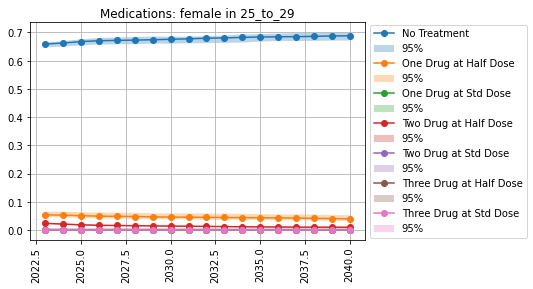

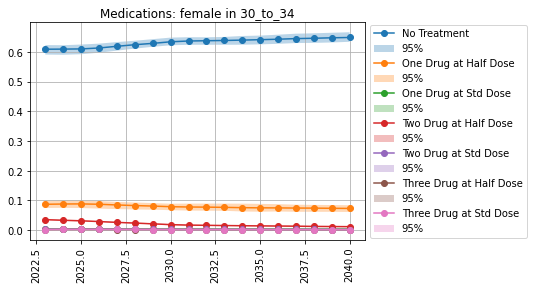

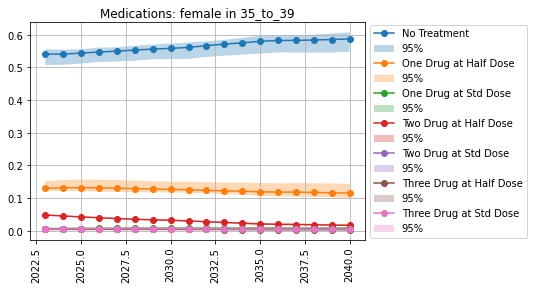

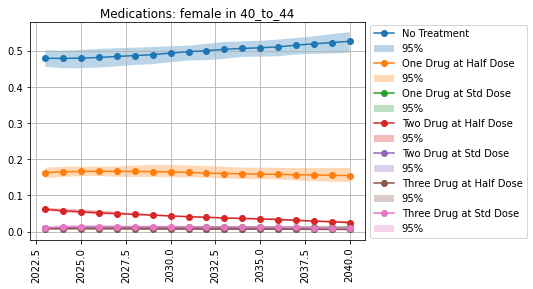

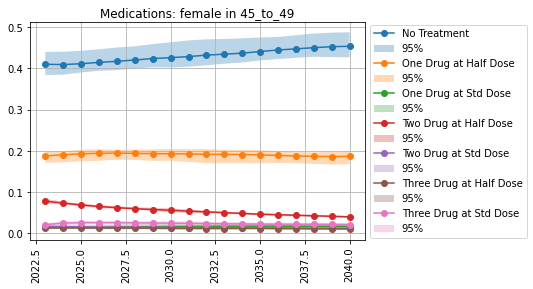

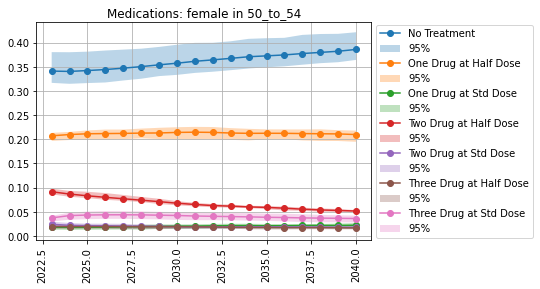

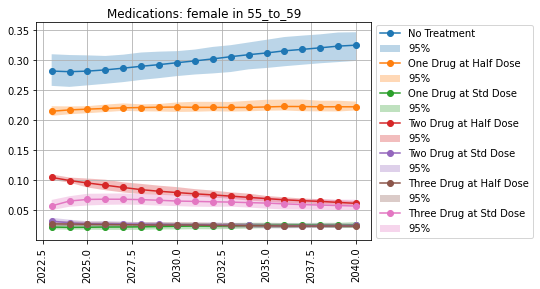

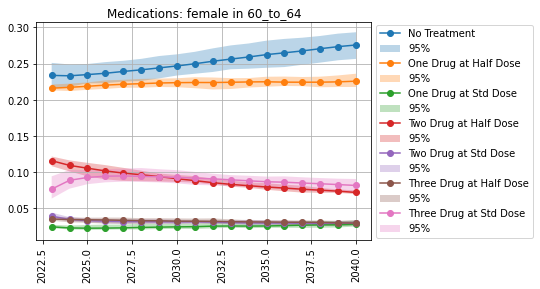

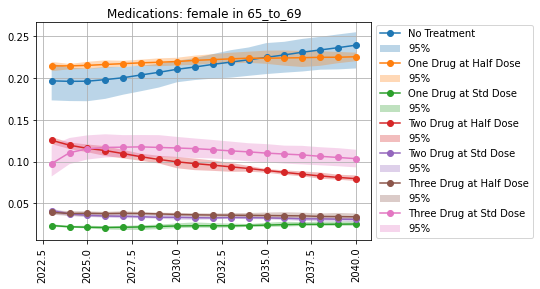

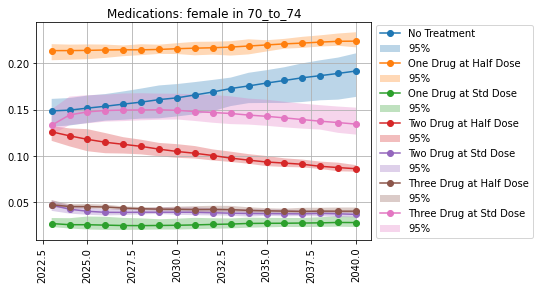

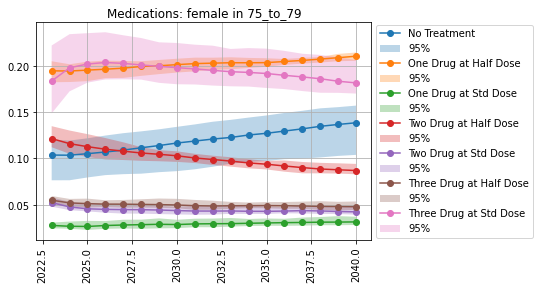

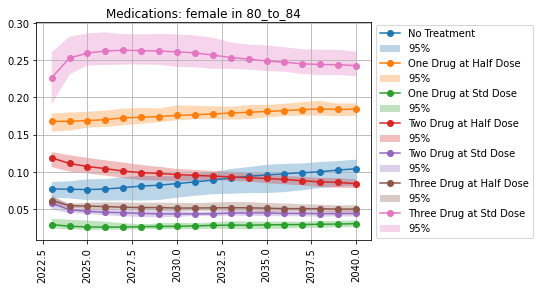

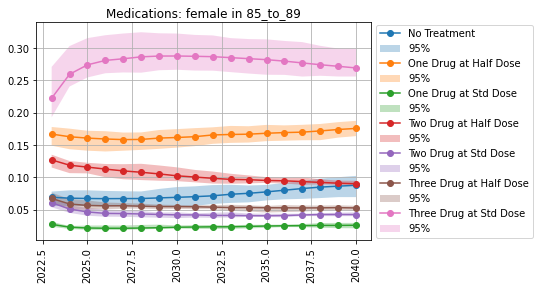

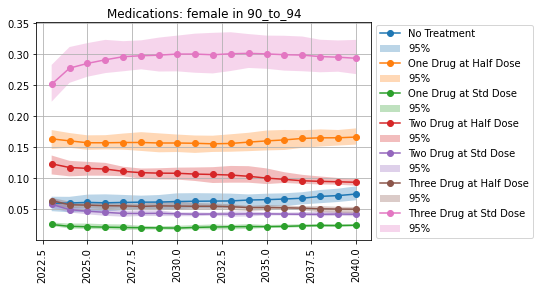

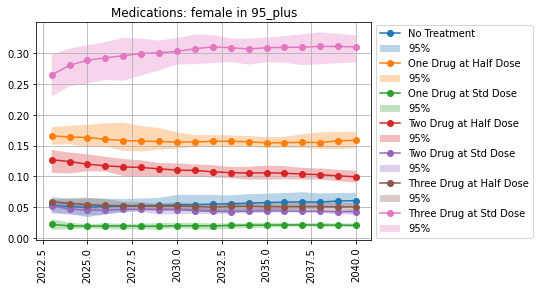

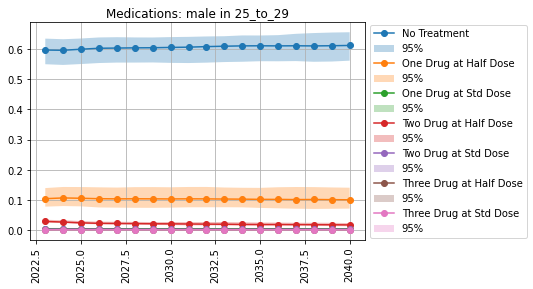

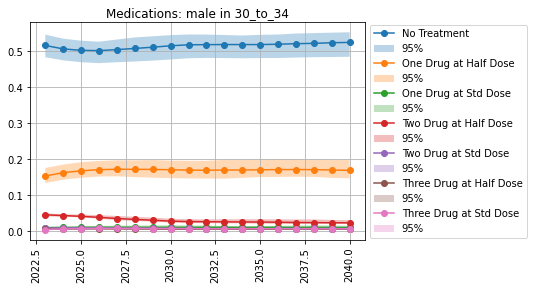

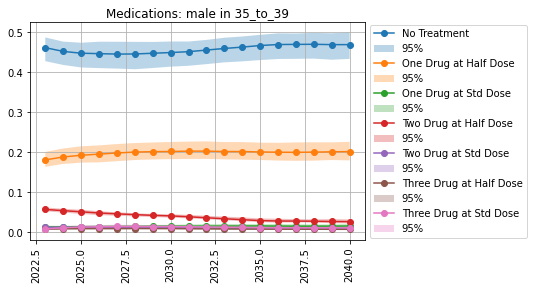

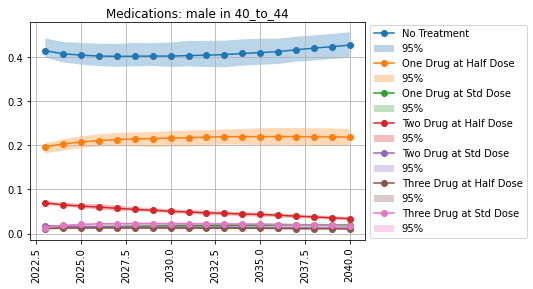

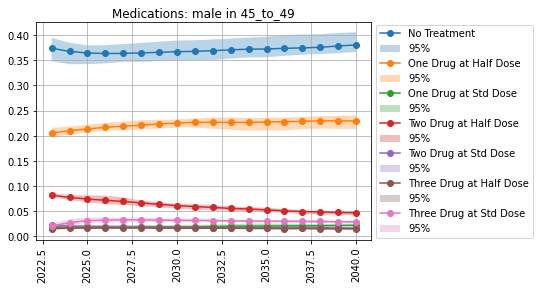

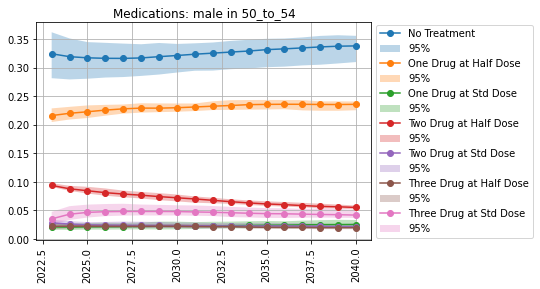

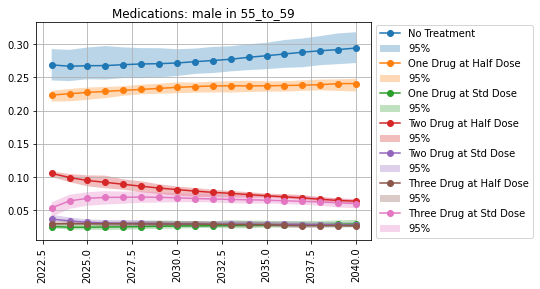

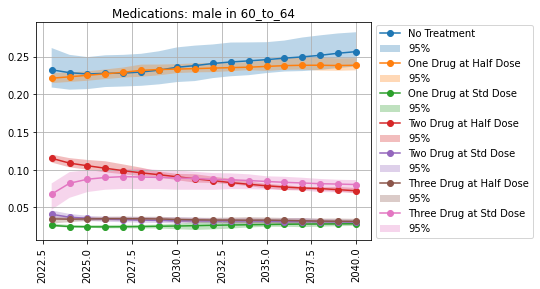

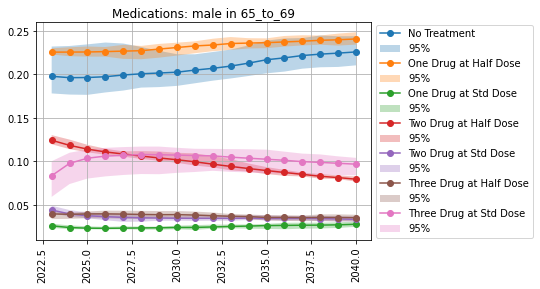

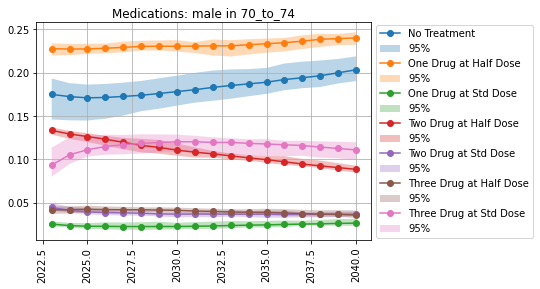

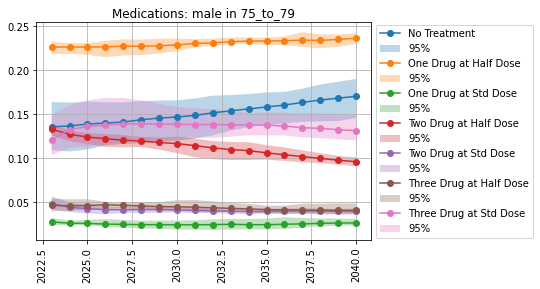

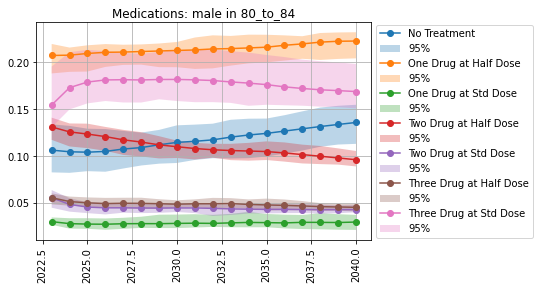

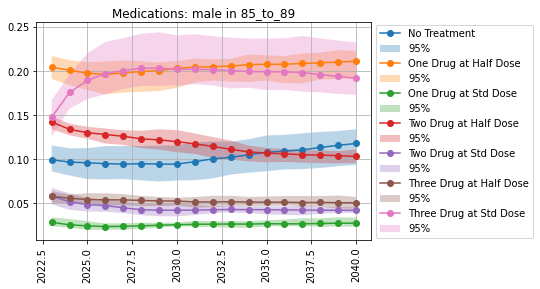

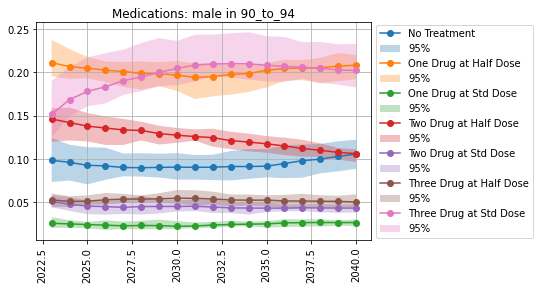

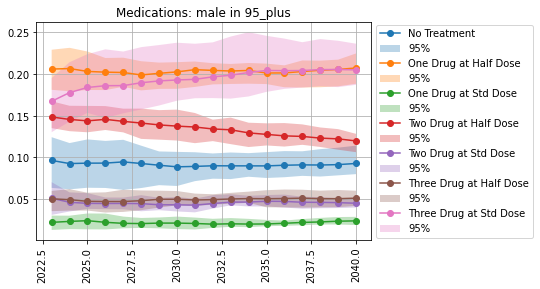

In [38]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
        plt.plot(three_std['year'], three_std['mean'], marker='o')
        plt.fill_between(three_std['year'], three_std['2.5%'], three_std['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'One Drug at Half Dose', '95%', 'One Drug at Std Dose','95%','Two Drug at Half Dose', '95%','Two Drug at Std Dose', '95%','Three Drug at Half Dose', '95%','Three Drug at Std Dose', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

In [39]:
ldl_meds = pd.read_csv(sim_results_dir + '/ldlc_medication_person_time.csv')
ldl_meds#.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,ldlc_medication,value
0,0,female,2023,ldlc_medication_person_time,29,baseline,25_to_29,primary_non_adherent,high_intensity,0.000000
1,1,female,2023,ldlc_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,high_intensity,0.000000
2,2,female,2023,ldlc_medication_person_time,29,baseline,25_to_29,adherent,high_intensity,245.694730
3,3,female,2023,ldlc_medication_person_time,29,baseline,30_to_34,primary_non_adherent,high_intensity,0.000000
...,...,...,...,...,...,...,...,...,...,...
97196,97196,male,2040,ldlc_medication_person_time,946,baseline,90_to_94,adherent,no_treatment,453.212868
97197,97197,male,2040,ldlc_medication_person_time,946,baseline,95_plus,primary_non_adherent,no_treatment,264.246407
97198,97198,male,2040,ldlc_medication_person_time,946,baseline,95_plus,secondary_non_adherent,no_treatment,93.524983
97199,97199,male,2040,ldlc_medication_person_time,946,baseline,95_plus,adherent,no_treatment,693.081451


In [40]:
per_time_group#.input_draw.unique()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27044.205339
1,25_to_29,female,2023,232,27050.951403
2,25_to_29,female,2023,357,26879.003422
3,25_to_29,female,2023,394,26896.941821
...,...,...,...,...,...
5396,95_plus,male,2040,650,4815.386721
5397,95_plus,male,2040,680,4473.407255
5398,95_plus,male,2040,829,3328.646133
5399,95_plus,male,2040,946,4560.569473


In [41]:
meds_adherent.input_draw.unique()

array([ 29, 232, 357, 394, 602, 629, 650, 680, 829, 946])

In [42]:
meds_adherent = ldl_meds.groupby(['sex','age','year','input_draw','ldlc_medication']).value.sum().reset_index()   #.loc[ldl_meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw']).reset_index()
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['age', 'sex', 'year', 'ldlc_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ#_test = meds_adherent_rate_summ.groupby(['age', 'sex', 'year'])['mean'].sum().reset_index()
#meds_adherent_rate_summ_test

,age,sex,year,ldlc_medication,mean,2.5%,97.5%
0,25_to_29,female,2023,high_intensity,0.008956,0.008394,0.009298
1,25_to_29,female,2023,high_with_eze,0.000000,0.000000,0.000000
2,25_to_29,female,2023,low_intensity,0.020741,0.019892,0.021778
3,25_to_29,female,2023,low_med_with_eze,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
3236,95_plus,male,2040,low_intensity,0.183735,0.170124,0.194674
3237,95_plus,male,2040,low_med_with_eze,0.075678,0.065036,0.089299
3238,95_plus,male,2040,medium_intensity,0.112144,0.104574,0.125856
3239,95_plus,male,2040,no_treatment,0.242168,0.209489,0.267462


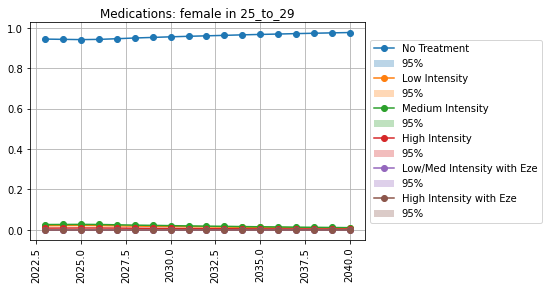

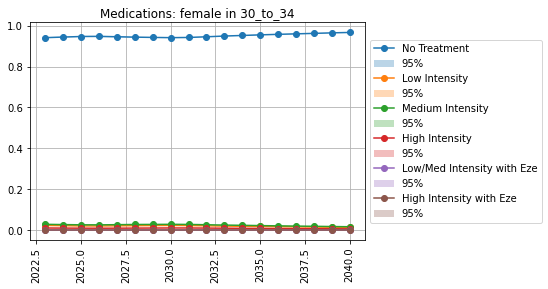

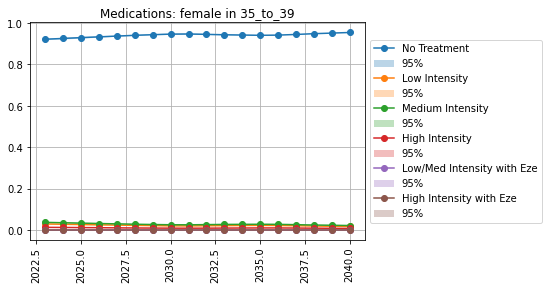

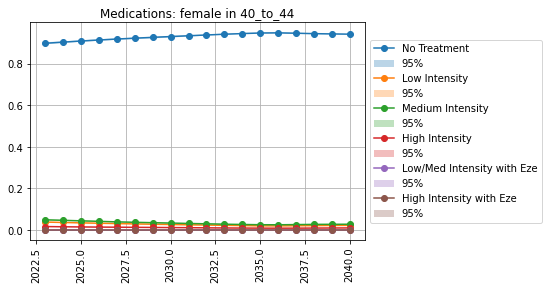

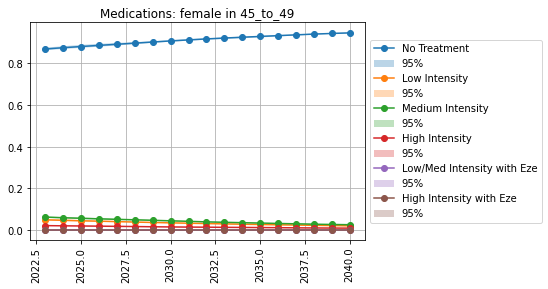

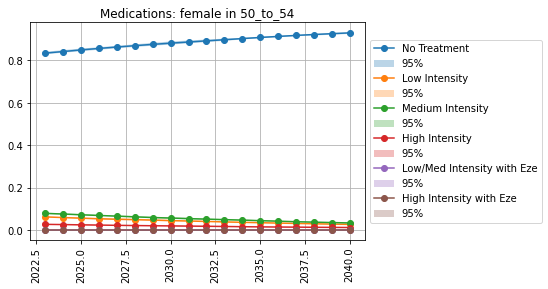

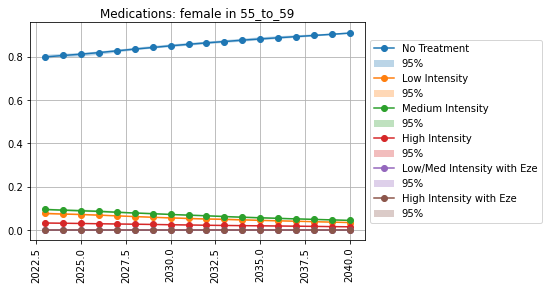

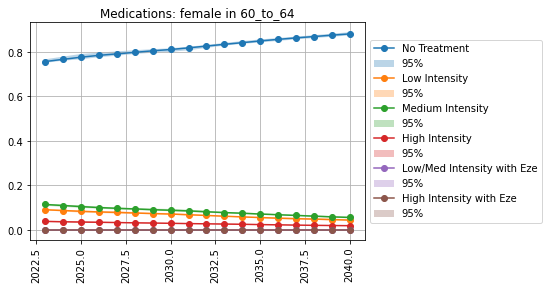

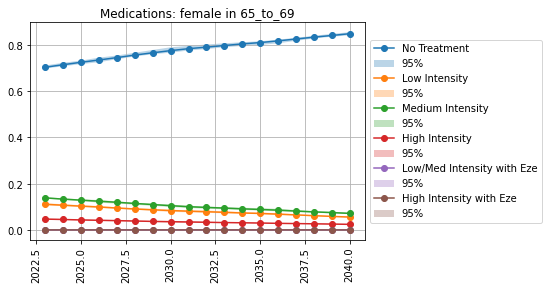

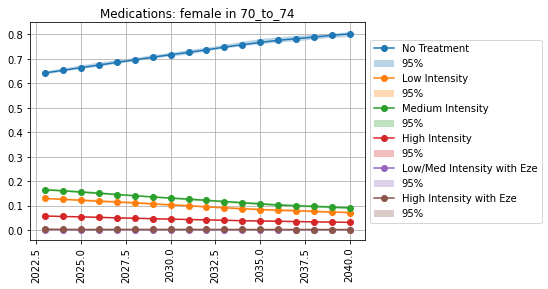

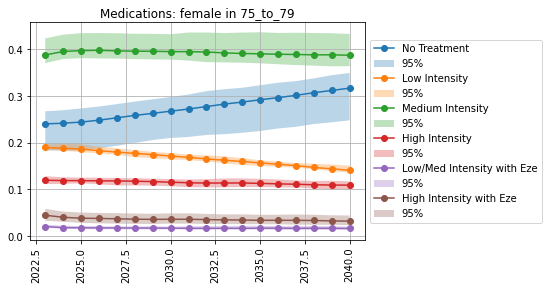

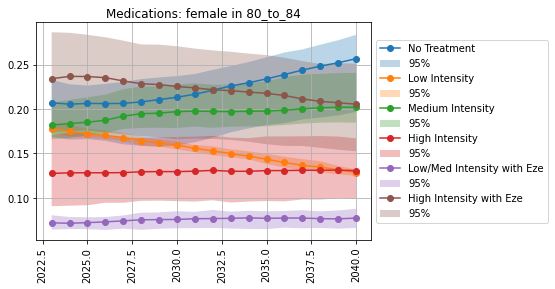

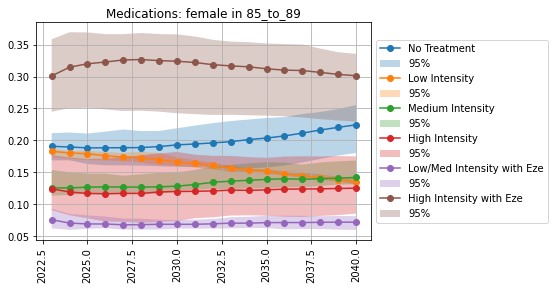

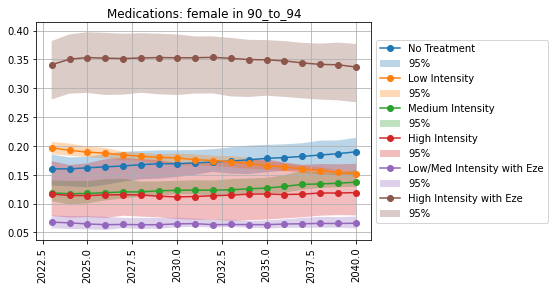

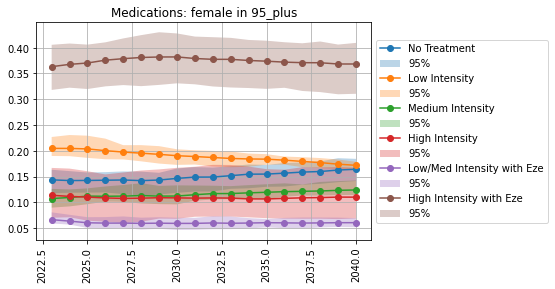

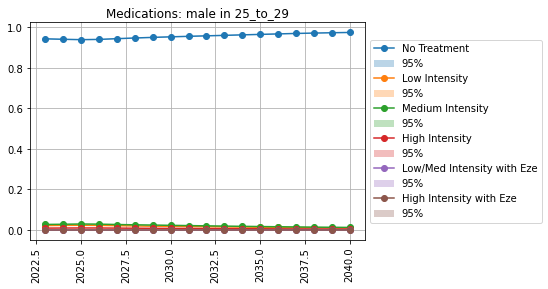

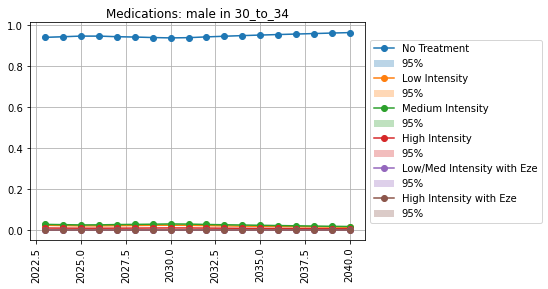

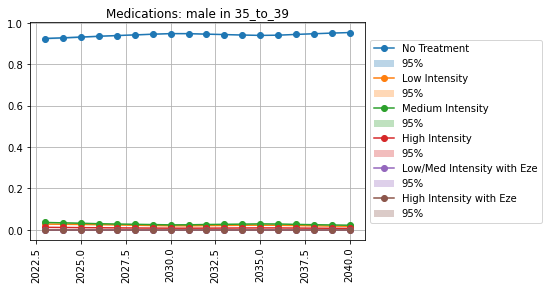

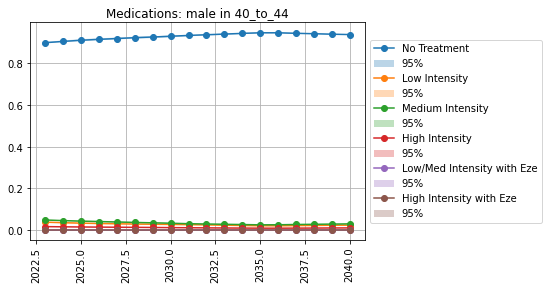

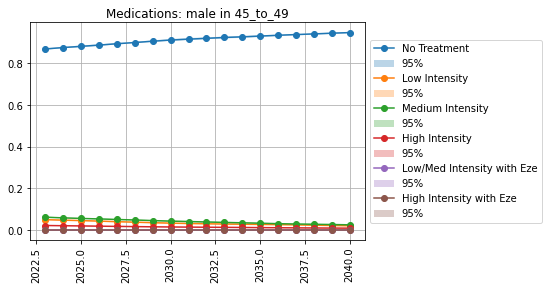

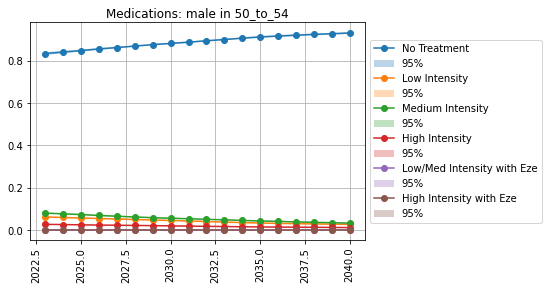

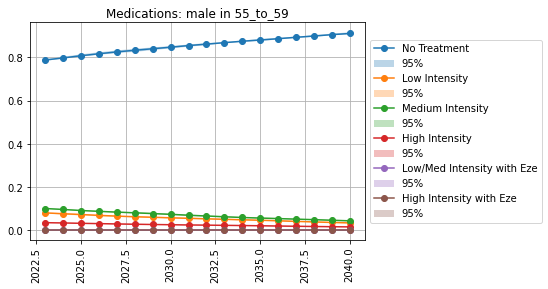

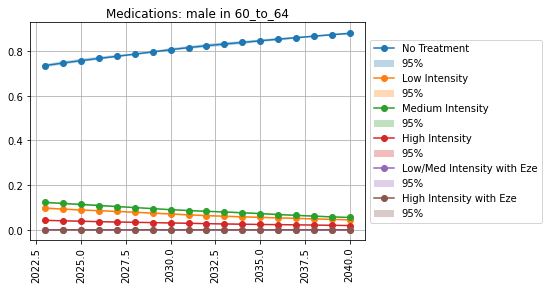

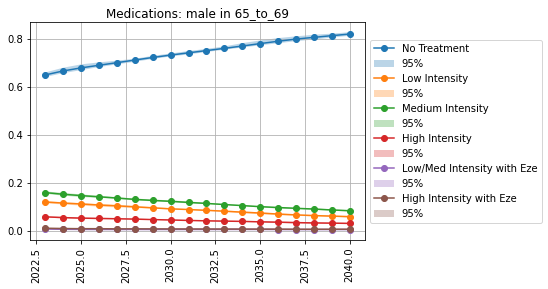

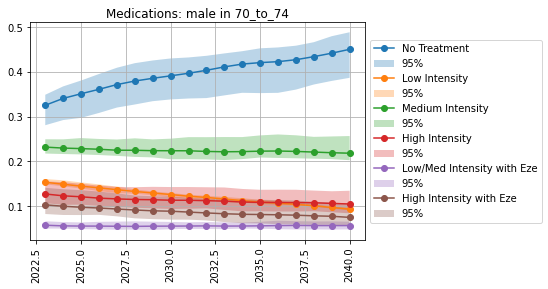

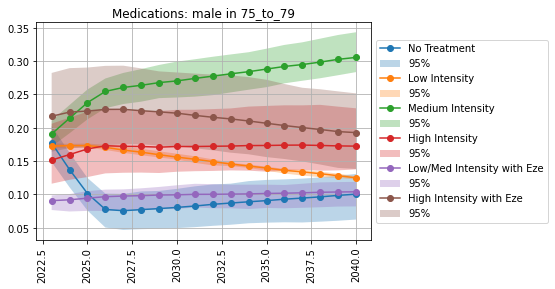

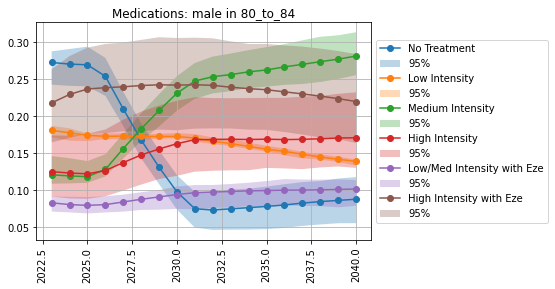

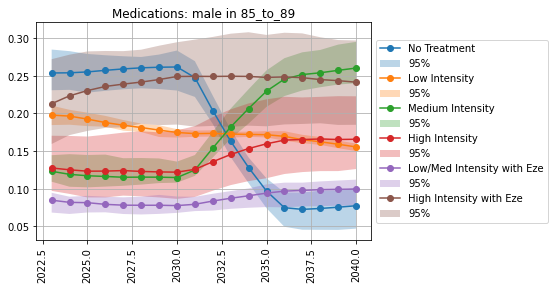

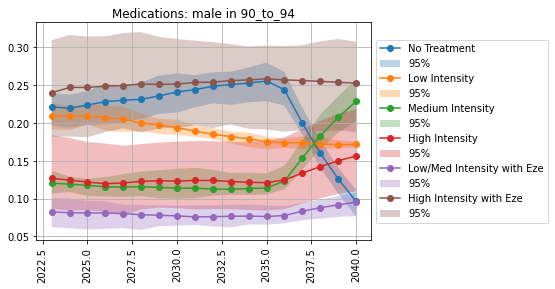

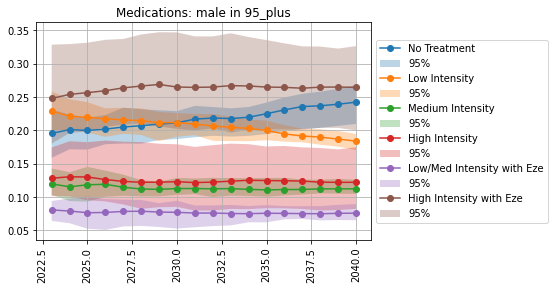

In [43]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'Low Intensity', '95%', 'Medium Intensity','95%','High Intensity', '95%','Low/Med Intensity with Eze', '95%','High Intensity with Eze', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()